# Introduction

## Background
To be successful with any restaurant opening, market research is the best thing to start off.

At one time, market researches before runing a business were implemented in traditional ways, like visiting local communities or interviewing potential customers. Whereas nowadays, the researches are largely facilitated since the machine learning power were added.

Data analyse and machine learning techniques play very important role in helping business people grab market share and become profitable when opening a restaurant in a smart and scientific way.



## Business Problem

A client seeks to establish a Chinese restaurant in Tokyo, Japan. 

This capstone report will determine the  optimal and most strategic location for running the restaurant by exploring the following questions:

* **Is the market saturated?** 
* **Who are the potential customers?**
* **Who are the local competitors?**

## Interests

This report will be targeted to stakeholders interested in opening an Chinese Cusine restaurant in Tokyo, Japan. Various factors such as over-saturation or no demand ,for the type of restaurant that the customer wants to open, effect the success or failure of the restaurant. Hence, customers can bolster their decisions using the descriptive and predictive capabilities of data science.

# Data Acquisition and Wrangling

## Data Sources

### Tokyo Wards Table from Wikipedia
#### I first make use of Special Wards of Tokyo page from [Wikipedia - Special Wards of Tokyo](https://en.wikipedia.org/wiki/Special_wards_of_Tokyo) to scrap the table to create a data-frame. Simply use pandas.read_html and then extract the target table.
#### Tokyo land price are downloaded from [Tokyo land market value](https://utinokati.com/en/details/land-market-value/area/Tokyo/)
#### For the demographical data, which will help analyse the potential customers are downloaded from [TOKYO STATISTICAL YEARBOOK 2018](https://www.toukei.metro.tokyo.lg.jp/tnenkan/2018/tn18q3e002.htm)

In [10]:
import lxml
import pandas as pd

# Set up dataframe display
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)


# Read all tables from Wiki Special wards of Tokyo Page into Dataframes. 
tables = pd.read_html('https://en.wikipedia.org/wiki/Special_wards_of_Tokyo')
# Find the table of Tokyo special wards
df = tables[3]

# Rename all columns
df.columns = ['No.', 'Flag', 'Name', 'Kanji', 'Population', 'Density', 'Area', 'Major district']

# Create dataframe of Tokyo special wards without Flag and Kanji
df_tokyo_wards = df[['Name', 'Population', 'Density', 'Area', 'Major district']]
df_tokyo_wards.head()

,Name,Population,Density,Area,Major district
0,Chiyoda,59441,5100,11.66,Nagatacho
1,Chuo,147620,14460,10.21,Nihonbashi
2,Minato,248071,12180,20.37,Odaiba
3,Shinjuku,339211,18620,18.22,Shinjuku
4,Bunkyo,223389,19790,11.29,Hongo


#### As we can see, there are too many districts major to each ward. Here I keep the first one as the major district of the ward.


In [11]:
# Keep the first distritc of the list as ward's Major distritc 
df_tokyo_wards['Major district'] = df_tokyo_wards['Major district'].str.split(',', expand=True)[0]

In [12]:
# Trim all special characters to English letters
df_tokyo_wards.Name.replace([r'\ū',r'\ō', r'Ō'],['u', 'o', 'O'], regex=True, inplace=True)
df_tokyo_wards['Major district'].replace([r'\ū',r'\ō', r'Ō'],['u', 'o', 'O'], regex=True, inplace=True)

In [13]:
df_tokyo_wards.dropna(inplace=True)
df_tokyo_wards.tail(10)

,Name,Population,Density,Area,Major district
13,Nakano,332902,21350,15.59,Nakano
14,Suginami,570483,16750,34.06,Koenji
15,Toshima,294673,22650,13.01,Ikebukuro
16,Kita,345063,16740,20.61,Akabane
17,Arakawa,213648,21030,10.16,Arakawa
18,Itabashi,569225,17670,32.22,Itabashi
19,Nerima,726748,15120,48.08,Nerima
20,Adachi,674067,12660,53.25,Ayase
21,Katsushika,447140,12850,34.80,Tateishi
22,Edogawa,685899,13750,49.90,Kasai


### Tokyo Land Prices and Demographical Feature Data

In [548]:
tokyo_prince_demo = pd.read_csv('./Tokyo_price_and_international_population.csv')
tokyo_prince_demo = tokyo_prince_demo.iloc[:20, :13]
tokyo_prince_demo.head()

,Major District,Average Unit Price\t(JPY/sq.m),China,Korea,Vietnam,Philippines,Nepal,U.S.A.,India,Myanmar,Thailand,Others,Total
0,Chiyoda,2602846.0,1250.0,455.0,76.0,64.0,24.0,210.0,79.0,16.0,46.0,582.0,2996.0
1,Chuo,2688537.0,3266.0,1401.0,192.0,153.0,95.0,391.0,275.0,38.0,89.0,1366.0,7651.0
2,Minato,2180846.0,3962.0,3461.0,144.0,1027.0,107.0,3257.0,649.0,56.0,191.0,6447.0,20057.0
3,Shinjuku,940756.0,14153.0,10221.0,3484.0,747.0,3517.0,1033.0,246.0,2218.0,735.0,4830.0,43068.0
4,Bunkyo,943847.0,4646.0,1658.0,927.0,223.0,364.0,329.0,107.0,317.0,192.0,1536.0,10808.0


### Getting the Longitudes and Latitudes of Major Districts from **Geopy Client**

#### Next objective is to get the coordinates of these 23 major districts using geocoder class of Geopy client

In [15]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent='Tokyo_explorer')
df_tokyo_wards['Major_district_geo'] = df_tokyo_wards['Major district'].apply(geolocator.geocode).apply(lambda x: (x.latitude, x.longitude))
df_tokyo_geo = df_tokyo_wards.copy()

In [16]:
# Drop the row with NaN values
df_tokyo_geo.dropna(inplace=True)

# switch string coordinations into tuple
df_tokyo_geo['Major_district_geo'] = df_tokyo_geo['Major_district_geo'].apply(lambda x: eval(x))

# flat the coordinations to latitude and longitude
df_tokyo_geo[['lat', 'long']] = df_tokyo_geo['Major_district_geo'].apply(pd.Series)

# drop coordination tuples
df_tokyo_geo.drop('Major_district_geo', axis=1, inplace=True)

df_tokyo_geo

,Name,Population,Density,Area,Major district,lat,long
0,Chiyoda,59441,5100,11.66,Nagatacho,35.675618,139.743469
1,Chuo,147620,14460,10.21,Nihonbashi,35.684068,139.774503
2,Minato,248071,12180,20.37,Odaiba,35.619050,139.779364
3,Shinjuku,339211,18620,18.22,Shinjuku,35.693763,139.703632
4,Bunkyo,223389,19790,11.29,Hongo,35.175376,137.013476
5,Taito,200486,19830,10.11,Ueno,35.711759,139.777645
6,Sumida,260358,18910,13.77,Kinshicho,35.696312,139.815043
7,Koto,502579,12510,40.16,Kiba,23.013134,-80.832875
8,Shinagawa,392492,17180,22.84,Shinagawa,35.599252,139.738910
9,Meguro,280283,19110,14.67,Meguro,35.621250,139.688014


#### The Percentage of Chinese Residents in All Districts
Some coordinations are not correct, therefore the data needs to be updated.

In [608]:
# Update lat, long for Kiba
df_tokyo_geo.iloc[7, -2] = 35.672200
df_tokyo_geo.iloc[7, -1] = 138.806100

# Update lat, long for Tateishi
df_tokyo_geo.iloc[21, -2] = 34.176335
df_tokyo_geo.iloc[21, -1] = 132.226020

# Update lat, long for Kasai
df_tokyo_geo.iloc[22, -2] = 35.663400
df_tokyo_geo.iloc[22, -1] = 139.873100

# Merge df_tokyo_geo and tokyo_prince_demo
df_tokyo_geo = df_tokyo_geo.join(tokyo_prince_demo.set_index('Major District'), on='Name').dropna()

df_tokyo_geo['China%'] = df_tokyo_geo.apply(lambda x: x.China / x.Population, axis=1)
df_tokyo_geo.head()

,Name,Population,Density,Area,Major district,lat,long,Average Unit Price\t(JPY/sq.m),China,Korea,Vietnam,Philippines,Nepal,U.S.A.,India,Myanmar,Thailand,Others,Total,China%
0,Chiyoda,59441,5100,11.66,Nagatacho,35.675618,139.743469,2602846.0,1250.0,455.0,76.0,64.0,24.0,210.0,79.0,16.0,46.0,582.0,2996.0,0.021029
1,Chuo,147620,14460,10.21,Nihonbashi,35.684068,139.774503,2688537.0,3266.0,1401.0,192.0,153.0,95.0,391.0,275.0,38.0,89.0,1366.0,7651.0,0.022124
2,Minato,248071,12180,20.37,Odaiba,35.619050,139.779364,2180846.0,3962.0,3461.0,144.0,1027.0,107.0,3257.0,649.0,56.0,191.0,6447.0,20057.0,0.015971
3,Shinjuku,339211,18620,18.22,Shinjuku,35.693763,139.703632,940756.0,14153.0,10221.0,3484.0,747.0,3517.0,1033.0,246.0,2218.0,735.0,4830.0,43068.0,0.041723
4,Bunkyo,223389,19790,11.29,Hongo,35.175376,137.013476,943847.0,4646.0,1658.0,927.0,223.0,364.0,329.0,107.0,317.0,192.0,1536.0,10808.0,0.020798


### Location Data by Foursquare API 
#### For returning the popular spots in the vicinity of each neighbourhood, Foursquare API will be utilized, more specifically, its explore function.

In [25]:
import requests

# define Foursquare credentials
CLIENT_ID = 'ND2O34KM3AFFVCYQY4LKBBOVXIDZCQJNQZI4X5YZWJ2CBCHK'
CLIENT_SECRET = 'ZBFCFCM0VMWZPD1KJHEIMY4QQPB1I5CEZ4VSZQP3MCO1SYJI'
VERSION = '20180605' 

# request definitions
LIMIT = 500 
radius = 5000

# function to get batch of venues as a dataframe
def get_nearby_venues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
#         print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [26]:
tokyo_venues = get_nearby_venues(
                        names=df_tokyo_geo['Major district'].iloc[:],
                        latitudes=df_tokyo_geo['lat'].iloc[:],
                        longitudes=df_tokyo_geo['long'].iloc[:]
                    )
tokyo_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Nagatacho,35.675618,139.743469,Nagatacho Kurosawa (永田町 黒澤),35.674699,139.741737,Japanese Restaurant
1,Nagatacho,35.675618,139.743469,The Capitol Hotel Tokyu (ザ・キャピトルホテル東急),35.673927,139.741019,Hotel
2,Nagatacho,35.675618,139.743469,Tully's Coffee,35.674594,139.743007,Coffee Shop
3,Nagatacho,35.675618,139.743469,Shinamen Hashigo (支那麺 はしご),35.672184,139.741576,Ramen Restaurant
4,Nagatacho,35.675618,139.743469,All Day Dining Origami (オールデイダイニング ORIGAMI),35.673815,139.741104,Restaurant


In [30]:
tokyo_venues.to_csv('./tokyo_venues.csv')

In [27]:
tokyo_venues.shape

(1299, 7)

# Methodology

## Exploratory Data Analysis

### Distributions of Restaurants in Tokyo

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#### Narrow down the venues to the places serve food
By filtering all restaurants and other places serve foods out of the venues dataframe, extract the information of local restaurant distributions. There are 195 unique categories. I will choose the places that contain "Restaurant" or seemingly serve food.

In [157]:
# Observe all venues, find the places that contain "Restaurant" or serve food
print('There are {} venue categories'.format(len(tokyo_venues['Venue Category'].unique())))
pd.DataFrame(tokyo_venues['Venue Category'].unique())


There are 195 venue categories


,0
0,Japanese Restaurant
1,Hotel
2,Coffee Shop
3,Ramen Restaurant
4,Restaurant
5,Sushi Restaurant
6,Bar
7,Sports Club
8,Indian Restaurant
9,Supermarket


#### Chinese Restaurant Distributions and Restaurant Ranks
There are 536 out of 1299 nearby venues serve f ood. By plotting a bar chart and annotating the frequency of their distributions, it is clearly that the most popular restaurant is "Ramen Restaurant" which has the top frequency of distribution at 13.8%. Followed by "Cafe" at 10.8%, "Japanese Restaurant" at 9.1%, "Chinese Restaurant" at 7.5% and "Coffee Shop" at 6.9%.

The number of Chinese restaurants are as half as that of Ramen restaurants, and it is 1% less than Japanese restaurant. Whereas the restaurants ranked below No.5 took at most half of the frequency of Chinese restaurants.

In [80]:
# tokyo_gourmets stores the places serve foods 
tokyo_gourmets = tokyo_venues.loc[tokyo_venues['Venue Category'].str.contains('Restaurant|Coffee|Café|Pizza|Breakfast|Noodle|Bistro|Burger', regex=True)]
display(tokyo_gourmets.head(), tokyo_gourmets.shape)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Nagatacho,35.675618,139.743469,Nagatacho Kurosawa (永田町 黒澤),35.674699,139.741737,Japanese Restaurant
2,Nagatacho,35.675618,139.743469,Tully's Coffee,35.674594,139.743007,Coffee Shop
3,Nagatacho,35.675618,139.743469,Shinamen Hashigo (支那麺 はしご),35.672184,139.741576,Ramen Restaurant
4,Nagatacho,35.675618,139.743469,All Day Dining Origami (オールデイダイニング ORIGAMI),35.673815,139.741104,Restaurant
5,Nagatacho,35.675618,139.743469,Sushi Isshin (鮨 一新),35.672589,139.739399,Sushi Restaurant


(536, 7)

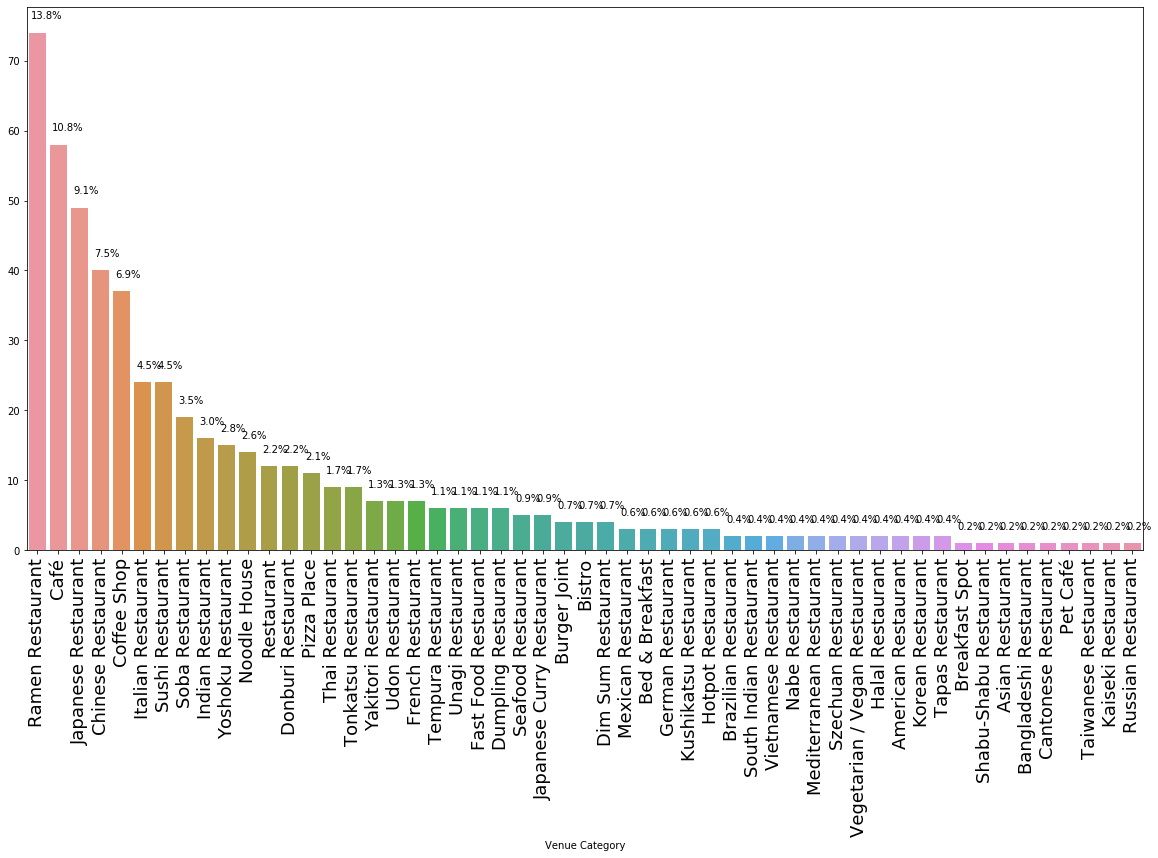

In [135]:
# set a figure to plot a bar chart 
plt.figure(figsize=(20,10))
ax = sns.countplot(
                    x='Venue Category', 
                    data=tokyo_gourmets,
                    order=tokyo_gourmets['Venue Category'].value_counts().index
            )
# plot settings
plt.xticks(size=18, rotation=90)
plt.ylabel('')

# annotate the frequency of distributions
total = len(tokyo_gourmets)*1.
for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+2))

plt.show()

#### What about the restaurant distribution of each ward?
The numberof restaurants and tokyo population are presented as follows. This will help analyse the relationship between market requirements and market size.

/Users/CherrieHe/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


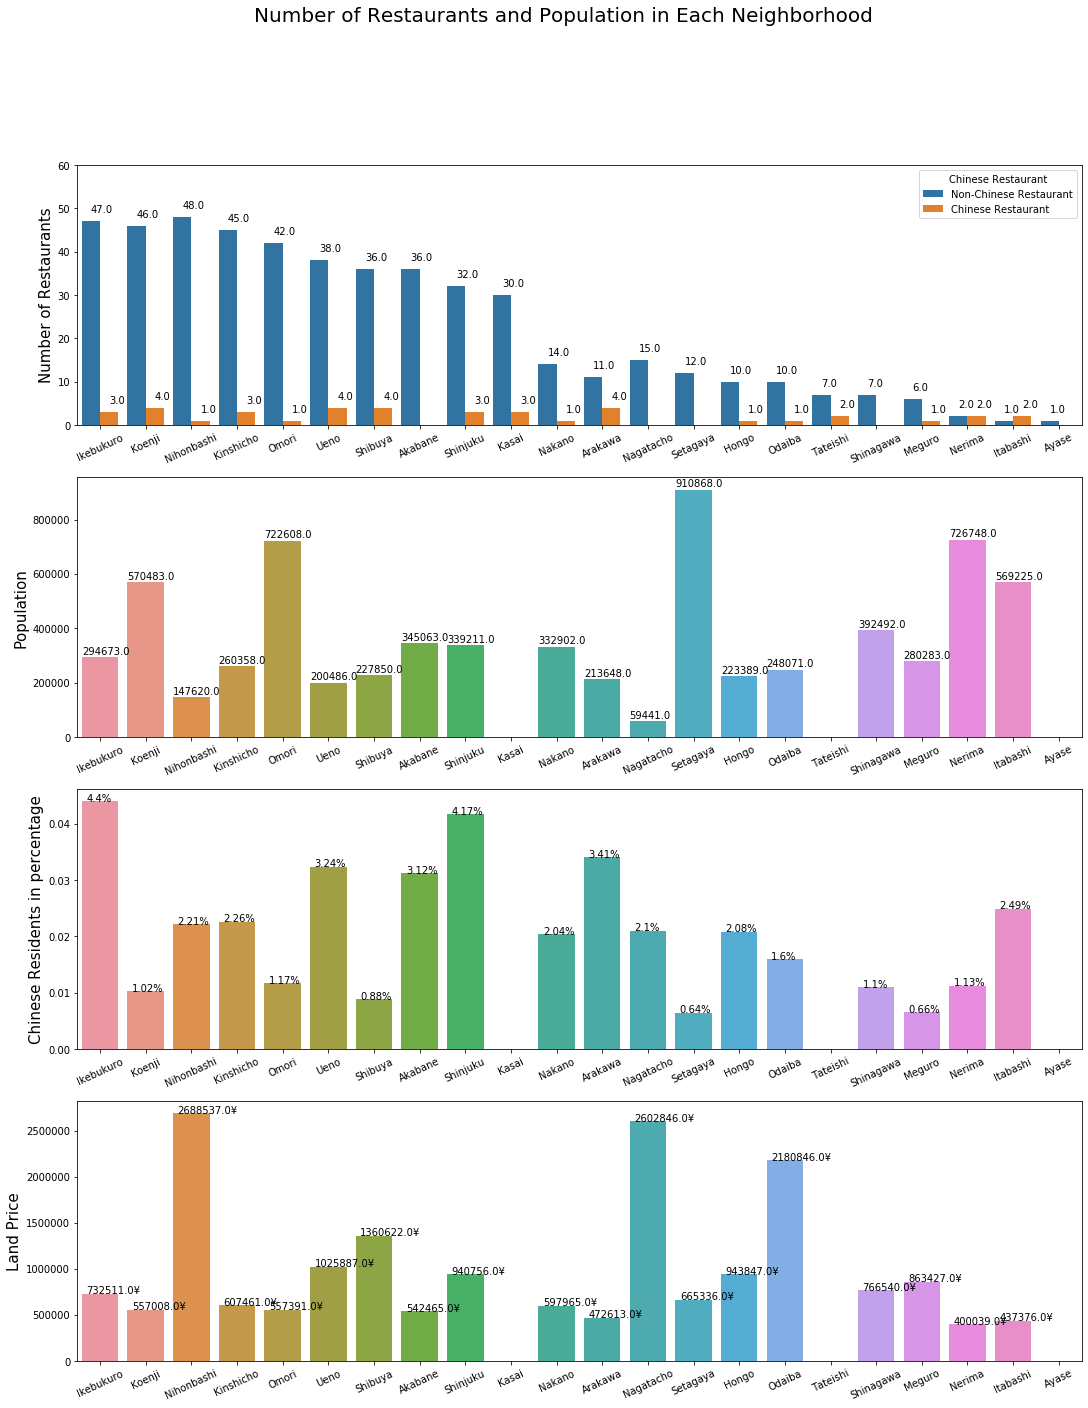

In [612]:
tokyo_gourmets['Chinese Restaurant'] = tokyo_gourmets['Venue Category'].apply(lambda x: 'Chinese Restaurant' if x == 'Chinese Restaurant' else 'Non-Chinese Restaurant')
tokyo_Chinese_restaurant = tokyo_gourmets.groupby(['Neighborhood', 'Chinese Restaurant'])['Venue'].count().unstack(['Chinese Restaurant']).fillna(0)

fig, axs = plt.subplots(4, 1, figsize=(18, 22))
fig.suptitle('Number of Restaurants and Population in Each Neighborhood', size=20)

sns.countplot(
                    x='Neighborhood', 
                    data=tokyo_gourmets, 
                    hue='Chinese Restaurant',
                    order=tokyo_gourmets['Neighborhood'].value_counts().index,
                    ax=axs[0]
)

sns.barplot(
                    df_tokyo_geo['Major district'],
                    df_tokyo_geo.Population,
                    order=tokyo_gourmets['Neighborhood'].value_counts().index,
                    ax=axs[1]
)

sns.barplot(
                    df_tokyo_geo['Major district'],
                    df_tokyo_geo['China%'],
                    order=tokyo_gourmets['Neighborhood'].value_counts().index,
                    ax=axs[2]
)

sns.barplot(
                    df_tokyo_geo['Major district'],
                    df_tokyo_geo['Average Unit Price\t(JPY/sq.m)'],
                    order=tokyo_gourmets['Neighborhood'].value_counts().index,
                    ax=axs[3]
)

axs[0].set_ylim(0, 60)
# axs[2].set_ylim(0, .7)
axs[0].set_ylabel('Number of Restaurants', size=15)
axs[1].set_ylabel('Population', size=15)
axs[2].set_ylabel('Chinese Residents in percentage', size=15)
axs[3].set_ylabel('Land Price', size=15)
axs[0].set_xlabel('')
axs[1].set_xlabel('')
axs[2].set_xlabel('')
axs[3].set_xlabel('')
axs[0].set_xticklabels(tokyo_gourmets['Neighborhood'].value_counts().index, rotation=25)
axs[1].set_xticklabels(tokyo_gourmets['Neighborhood'].value_counts().index, rotation=25)
axs[2].set_xticklabels(tokyo_gourmets['Neighborhood'].value_counts().index, rotation=25)
axs[3].set_xticklabels(tokyo_gourmets['Neighborhood'].value_counts().index, rotation=25)

for p in axs[0].patches:
    axs[0].annotate('{}'.format(p.get_height()), (p.get_x()+0.2, p.get_height()+2), size=10)

for p in axs[1].patches:
    axs[1].annotate('{}'.format(p.get_height()), (p.get_x(), p.get_height()+10000), size=10)

for p in axs[2].patches:
    axs[2].annotate('{}%'.format(round(p.get_height() * 100, 2)), (p.get_x()+.1, p.get_height()), size=10)

for p in axs[3].patches:
    axs[3].annotate('{}¥'.format(p.get_height()), (p.get_x()+.1, p.get_height()), size=10)

plt.show()

In [254]:
pv_gourmets = pd.pivot_table(tokyo_gourmets,index=['Neighborhood', 'Venue Category'], values = ['Venue'], aggfunc='count', ).sort_index(
   axis=1, ascending=False)

ward_gourmet_ranks = pv_gourmets.reset_index().sort_values(['Neighborhood','Venue'], ascending=[1,0]).set_index(['Neighborhood','Venue Category'])hjjjjjjjjyt
ward_gourmet_ranks


Venue
Neighborhood Venue Category                      
Akabane      Ramen Restaurant                   6
             Soba Restaurant                    4
             Coffee Shop                        3
             Café                               2
             Dumpling Restaurant                2
             Indian Restaurant                  2
             Italian Restaurant                 2
             Japanese Curry Restaurant          2
             Japanese Restaurant                2
             Kushikatsu Restaurant              2
             Yakitori Restaurant                2
             Bistro                             1
             Donburi Restaurant                 1
             Fast Food Restaurant               1
             Noodle House                       1
             Restaurant                         1
             Sushi Restaurant                   1
             Unagi Restaurant                   1
Arakawa      Chinese Restaurant                 4
             Ramen Restaurant                   3
             Noodle House                       2
             Burger Joint                       1
             Café                               1
             Coffee Shop                        1
             Donburi Restaurant                 1
             Italian Restaurant                 1
             Soba Restaurant                    1
Ayase        Udon Restaurant                    1
Hongo        Café                               2
             Bistro                             1
             Chinese Restaurant                 1
             Indian Restaurant                  1
             Japanese Restaurant                1
             Mediterranean Restaurant           1
             Noodle House                       1
             Pizza Place                        1
             Ramen Restaurant                   1
             Sushi Restaurant                   1
Ikebukuro    Café                               8
             Japanese Restaurant                6
             Sushi Restaurant                   6
             Yoshoku Restaurant                 5
             Coffee Shop                        4
             Ramen Restaurant                   4
             Chinese Restaurant                 3
             Dim Sum Restaurant                 2
             Asian Restaurant                   1
             Donburi Restaurant                 1
             French Restaurant                  1
             German Restaurant                  1
             Hotpot Restaurant                  1
             Italian Restaurant                 1
             Noodle House                       1
             Pet Café                           1
             Pizza Place                        1
             Seafood Restaurant                 1
             Szechuan Restaurant                1
             Udon Restaurant                    1
Itabashi     Chinese Restaurant                 2
             Restaurant                         1
Kasai        Ramen Restaurant                   7
             Indian Restaurant                  5
             Chinese Restaurant                 3
             Donburi Restaurant                 3
             Fast Food Restaurant               3
             Japanese Restaurant                2
             Café                               1
             Coffee Shop                        1
             Dumpling Restaurant                1
             French Restaurant                  1
             Japanese Curry Restaurant          1
             Noodle House                       1
             Pizza Place                        1
             Restaurant                         1
             Soba Restaurant                    1
             Sushi Restaurant                   1
Kinshicho    Ramen Restaurant                   9
             Coffee Shop                        6
             Chinese Restaurant             

In [256]:
# one hot encoding
tokyo_onehot = pd.get_dummies(tokyo_gourmets[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
tokyo_onehot['Neighborhood'] = tokyo_gourmets['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [tokyo_onehot.columns[-1]] + list(tokyo_onehot.columns[:-1])
tokyo_onehot.head()
tokyo_grouped = tokyo_onehot.groupby('Neighborhood').mean().reset_index()
tokyo_grouped.head()

num_top_venues = 3

for hood in tokyo_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = tokyo_grouped[tokyo_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Akabane----
              venue  freq
0  Ramen Restaurant  0.17
1   Soba Restaurant  0.11
2       Coffee Shop  0.08


----Arakawa----
                venue  freq
0  Chinese Restaurant  0.27
1    Ramen Restaurant  0.20
2        Noodle House  0.13


----Ayase----
                     venue  freq
0          Udon Restaurant   1.0
1      American Restaurant   0.0
2  South Indian Restaurant   0.0


----Hongo----
                 venue  freq
0                 Café  0.18
1  Japanese Restaurant  0.09
2         Noodle House  0.09


----Ikebukuro----
                 venue  freq
0                 Café  0.16
1  Japanese Restaurant  0.12
2     Sushi Restaurant  0.12


----Itabashi----
                 venue  freq
0   Chinese Restaurant  0.67
1           Restaurant  0.33
2  American Restaurant  0.00


----Kasai----
                venue  freq
0    Ramen Restaurant  0.21
1   Indian Restaurant  0.15
2  Donburi Restaurant  0.09


----Kinshicho----
              venue  freq
0  Ramen Restaurant  0.19

## Folium Mapping Visualisation

In [173]:
import folium

tokyo_map = folium.Map(location=[35.689800, 139.693200], zoom_start=12)

neighborhoods = folium.map.FeatureGroup()

for lat, lng, in zip(tokyo_gourmets['Neighborhood Latitude'], tokyo_gourmets['Neighborhood Longitude']):
    neighborhoods.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=20, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.2
        )
    )
    
    
restaurants = folium.map.FeatureGroup()    
for lat, lng, in zip(tokyo_gourmets['Venue Latitude'], tokyo_gourmets['Venue Longitude']):
    restaurants.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=2, # define how big you want the circle markers to be
            color='cyan',
            fill=True,
            fill_color='red',
            fill_opacity=0.6
        )
    )


# add incidents to map
tokyo_map.add_child(neighborhoods)
tokyo_map.add_child(restaurants)


## Clustering Neighborhoods in Tokyo

Based on the similarities of venue categories, 22 neighborhood will be clustered by using K-Means. Clustered neighborhoods will be labelled from 0-4. 

#### Pre-processing

In [472]:
tokyo_grouped = tokyo_onehot.groupby('Neighborhood').mean().reset_index()
tokyo_grouped.head()

,Neighborhood,American Restaurant,Asian Restaurant,Bangladeshi Restaurant,Bed & Breakfast,Bistro,Brazilian Restaurant,Breakfast Spot,Burger Joint,Café,...,Tapas Restaurant,Tempura Restaurant,Thai Restaurant,Tonkatsu Restaurant,Udon Restaurant,Unagi Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Yakitori Restaurant,Yoshoku Restaurant
0,Akabane,0.0,0.00,0.0,0.0,0.027778,0.0,0.0,0.000000,0.055556,...,0.0,0.0,0.0,0.0,0.00,0.027778,0.0,0.0,0.055556,0.0
1,Arakawa,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,0.066667,0.066667,...,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.000000,0.0
2,Ayase,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,1.00,0.000000,0.0,0.0,0.000000,0.0
3,Hongo,0.0,0.00,0.0,0.0,0.090909,0.0,0.0,0.000000,0.181818,...,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.000000,0.0
4,Ikebukuro,0.0,0.02,0.0,0.0,0.000000,0.0,0.0,0.000000,0.160000,...,0.0,0.0,0.0,0.0,0.02,0.000000,0.0,0.0,0.000000,0.1


In [479]:
import numpy as np

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = tokyo_grouped['Neighborhood']

for ind in np.arange(tokyo_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(tokyo_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Akabane,Ramen Restaurant,Soba Restaurant,Coffee Shop,Café,Japanese Restaurant,Indian Restaurant,Yakitori Restaurant,Dumpling Restaurant,Italian Restaurant,Kushikatsu Restaurant
1,Arakawa,Chinese Restaurant,Ramen Restaurant,Noodle House,Soba Restaurant,Italian Restaurant,Burger Joint,Café,Coffee Shop,Donburi Restaurant,Fast Food Restaurant
2,Ayase,Udon Restaurant,Yoshoku Restaurant,Dim Sum Restaurant,Japanese Restaurant,Japanese Curry Restaurant,Italian Restaurant,Indian Restaurant,Hotpot Restaurant,Halal Restaurant,German Restaurant
3,Hongo,Café,Noodle House,Chinese Restaurant,Ramen Restaurant,Indian Restaurant,Mediterranean Restaurant,Bistro,Japanese Restaurant,Pizza Place,Sushi Restaurant
4,Ikebukuro,Café,Japanese Restaurant,Sushi Restaurant,Yoshoku Restaurant,Ramen Restaurant,Coffee Shop,Chinese Restaurant,Dim Sum Restaurant,Italian Restaurant,Pet Café


In [475]:
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 5

tokyo_grouped_clustering = tokyo_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(tokyo_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

(array([2, 2, 1, 2, 2, 4, 2, 2, 2, 0, 0, 2, 3, 0, 0, 2, 2, 2, 0, 2, 2, 2],
       dtype=int32), 22)

In [500]:
neighborhoods_venues_sorted.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,2,Akabane,Ramen Restaurant,Soba Restaurant,Coffee Shop,Café,Japanese Restaurant,Indian Restaurant,Yakitori Restaurant,Dumpling Restaurant,Italian Restaurant,Kushikatsu Restaurant
1,2,Arakawa,Chinese Restaurant,Ramen Restaurant,Noodle House,Soba Restaurant,Italian Restaurant,Burger Joint,Café,Coffee Shop,Donburi Restaurant,Fast Food Restaurant
2,1,Ayase,Udon Restaurant,Yoshoku Restaurant,Dim Sum Restaurant,Japanese Restaurant,Japanese Curry Restaurant,Italian Restaurant,Indian Restaurant,Hotpot Restaurant,Halal Restaurant,German Restaurant
3,2,Hongo,Café,Noodle House,Chinese Restaurant,Ramen Restaurant,Indian Restaurant,Mediterranean Restaurant,Bistro,Japanese Restaurant,Pizza Place,Sushi Restaurant
4,2,Ikebukuro,Café,Japanese Restaurant,Sushi Restaurant,Yoshoku Restaurant,Ramen Restaurant,Coffee Shop,Chinese Restaurant,Dim Sum Restaurant,Italian Restaurant,Pet Café


In [492]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

tokyo_merged = df_tokyo_geo

# merge tokyo_grouped with tokyo_data to add latitude/longitude for each neighborhood
tokyo_merged = tokyo_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Major district')

tokyo_merged.head(5) 

,Name,Population,Density,Area,Major district,lat,long,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Chiyoda,59441,5100,11.66,Nagatacho,35.675618,139.743469,0.0,Coffee Shop,Japanese Restaurant,Café,Ramen Restaurant,Soba Restaurant,Sushi Restaurant,Pizza Place,Restaurant,Indian Restaurant,Kaiseki Restaurant
1,Chuo,147620,14460,10.21,Nihonbashi,35.684068,139.774503,0.0,Japanese Restaurant,Coffee Shop,Yoshoku Restaurant,Ramen Restaurant,Café,Italian Restaurant,French Restaurant,Tempura Restaurant,Dim Sum Restaurant,Sushi Restaurant
2,Minato,248071,12180,20.37,Odaiba,35.619050,139.779364,0.0,Japanese Restaurant,Coffee Shop,Yakitori Restaurant,Italian Restaurant,Ramen Restaurant,Restaurant,Chinese Restaurant,Sushi Restaurant,Yoshoku Restaurant,Dumpling Restaurant
3,Shinjuku,339211,18620,18.22,Shinjuku,35.693763,139.703632,2.0,Ramen Restaurant,Japanese Restaurant,Chinese Restaurant,Tonkatsu Restaurant,Italian Restaurant,Noodle House,Soba Restaurant,Yoshoku Restaurant,Russian Restaurant,Bed & Breakfast
4,Bunkyo,223389,19790,11.29,Hongo,35.175376,137.013476,2.0,Café,Noodle House,Chinese Restaurant,Ramen Restaurant,Indian Restaurant,Mediterranean Restaurant,Bistro,Japanese Restaurant,Pizza Place,Sushi Restaurant


#### Visualise all clusters

In [493]:
tokyo_merged.dropna(inplace=True)
tokyo_merged['Cluster Labels'] = tokyo_merged['Cluster Labels'].astype(int)

In [499]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[35.689800, 139.693200], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(tokyo_merged['lat'], tokyo_merged['long'], tokyo_merged['Major district'], tokyo_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.9).add_to(map_clusters)
       
map_clusters

#### Display All Detials of Each Cluster

In [519]:
def display_clusters(label):
    return tokyo_merged.loc[tokyo_merged['Cluster Labels'] == label, tokyo_merged.columns[[4] + list(range(5, tokyo_merged.shape[1]))]]

for i in range(0, 5):
    print('Cluster: {}'.format(i))
    display(display_clusters(i))


Cluster: 0


,Major district,lat,long,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Nagatacho,35.675618,139.743469,0,Coffee Shop,Japanese Restaurant,Café,Ramen Restaurant,Soba Restaurant,Sushi Restaurant,Pizza Place,Restaurant,Indian Restaurant,Kaiseki Restaurant
1,Nihonbashi,35.684068,139.774503,0,Japanese Restaurant,Coffee Shop,Yoshoku Restaurant,Ramen Restaurant,Café,Italian Restaurant,French Restaurant,Tempura Restaurant,Dim Sum Restaurant,Sushi Restaurant
2,Odaiba,35.619050,139.779364,0,Japanese Restaurant,Coffee Shop,Yakitori Restaurant,Italian Restaurant,Ramen Restaurant,Restaurant,Chinese Restaurant,Sushi Restaurant,Yoshoku Restaurant,Dumpling Restaurant
8,Shinagawa,35.599252,139.738910,0,Donburi Restaurant,Soba Restaurant,Pizza Place,Restaurant,Sushi Restaurant,Japanese Restaurant,Dim Sum Restaurant,Italian Restaurant,Indian Restaurant,Hotpot Restaurant
9,Meguro,35.621250,139.688014,0,Japanese Restaurant,Chinese Restaurant,Italian Restaurant,Noodle House,Sushi Restaurant,Coffee Shop,Brazilian Restaurant,Fast Food Restaurant,Japanese Curry Restaurant,Asian Restaurant


Cluster: 1


,Major district,lat,long,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,Ayase,35.446047,139.430823,1,Udon Restaurant,Yoshoku Restaurant,Dim Sum Restaurant,Japanese Restaurant,Japanese Curry Restaurant,Italian Restaurant,Indian Restaurant,Hotpot Restaurant,Halal Restaurant,German Restaurant


Cluster: 2


,Major district,lat,long,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Shinjuku,35.693763,139.703632,2,Ramen Restaurant,Japanese Restaurant,Chinese Restaurant,Tonkatsu Restaurant,Italian Restaurant,Noodle House,Soba Restaurant,Yoshoku Restaurant,Russian Restaurant,Bed & Breakfast
4,Hongo,35.175376,137.013476,2,Café,Noodle House,Chinese Restaurant,Ramen Restaurant,Indian Restaurant,Mediterranean Restaurant,Bistro,Japanese Restaurant,Pizza Place,Sushi Restaurant
5,Ueno,35.711759,139.777645,2,Ramen Restaurant,Japanese Restaurant,Chinese Restaurant,Café,Yoshoku Restaurant,Bed & Breakfast,Tonkatsu Restaurant,Thai Restaurant,Italian Restaurant,Sushi Restaurant
6,Kinshicho,35.696312,139.815043,2,Ramen Restaurant,Coffee Shop,Chinese Restaurant,Thai Restaurant,Japanese Restaurant,Sushi Restaurant,Pizza Place,Café,Nabe Restaurant,Cantonese Restaurant
10,Omori,35.588473,139.727933,2,Coffee Shop,Café,Ramen Restaurant,Soba Restaurant,Japanese Restaurant,Indian Restaurant,Tonkatsu Restaurant,Tempura Restaurant,Italian Restaurant,Sushi Restaurant
11,Setagaya,35.646096,139.656270,2,Café,Ramen Restaurant,Restaurant,Japanese Restaurant,Unagi Restaurant,Pizza Place,Bistro,Fast Food Restaurant,Szechuan Restaurant,Yoshoku Restaurant
12,Shibuya,35.664596,139.698711,2,Café,Japanese Restaurant,Ramen Restaurant,Chinese Restaurant,French Restaurant,South Indian Restaurant,Mexican Restaurant,Nabe Restaurant,Noodle House,Restaurant
13,Nakano,35.718123,139.664468,2,Ramen Restaurant,Café,Coffee Shop,Chinese Restaurant,Sushi Restaurant,Pizza Place,Noodle House,Tonkatsu Restaurant,Italian Restaurant,Donburi Restaurant
14,Koenji,35.704942,139.649909,2,Ramen Restaurant,Café,Italian Restaurant,Chinese Restaurant,Dumpling Restaurant,Indian Restaurant,Japanese Restaurant,Yakitori Restaurant,Mexican Restaurant,Noodle House
15,Ikebukuro,35.730103,139.711884,2,Café,Japanese Restaurant,Sushi Restaurant,Yoshoku Restaurant,Ramen Restaurant,Coffee Shop,Chinese Restaurant,Dim Sum Restaurant,Italian Restaurant,Pet Café


Cluster: 3


,Major district,lat,long,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,Nerima,35.74836,139.638735,3,Café,Chinese Restaurant,Yoshoku Restaurant,Donburi Restaurant,Japanese Restaurant,Japanese Curry Restaurant,Italian Restaurant,Indian Restaurant,Hotpot Restaurant,Halal Restaurant


Cluster: 4


,Major district,lat,long,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Itabashi,35.774143,139.681209,4,Chinese Restaurant,Restaurant,Yoshoku Restaurant,Donburi Restaurant,Japanese Restaurant,Japanese Curry Restaurant,Italian Restaurant,Indian Restaurant,Hotpot Restaurant,Halal Restaurant


# Results

As stated at the beginning of this project, this report will answer the following questions by exploring the geographical and market data with the machine learning power deployed.
* **Is the market saturated?**  
    Ramen restaurants are the most frequently distributed among all districts, which is followed by Cafe and Japanese restaurants, whereas Chinese restaurants are almost 50% less than the Ramen restaurants distribution frequency. It indicates:
        1. Opening a Chinese restaurant is easier than that for a Ramen restaurant. Because the market for Ramen restaurant are more likely to be saturated, which would bring fierce market competition.
        2. Chinese restaurants might not as popular as Ramen and Japanese Restaurants.
        3. Districts like Ikebukuro, Shinjuku, Ueno and Itabashi, that have higher Chinese residents proportions and relatively low land prices are most likely to be selected as the most strategical places to open a Chinese restaurant. Those districts are labelled as Cluster 2.
    
* **Who are the potential customers?**  
    Both Chinese residents and Non-Chinese residents are potential customers. The percentage of Chinese residents in Arakawa and Itabashi, where take the Chinese restaurant as their 1st Most Common Venue, are not the highest ones. This might point the Chinese restaurants are popular to not just Chinese Residents.
    
    
* **Who are the local competitors?**  
    Although Chinese restaurants are the 1st or 2nd popular restaurants for some districts, however there are at most 4 Chinese restaurants out of the popular restaurants of each districts. Chinese restaurants performed lower market occupancy than Ramen and Cafe, but they are much frequently distributed than all other kind of restaurants.  Therefore, the main competitors of Chinese Restaurants are Japanese restaurants, especially Ramen restaurants.
    
**According to my analysis, Cluster 2, where Chinese restaurants with low ranking of popularity, but with high Chinese residents proportions and fairly low land prices, are the most optimal locations to open a Chinese restaurant.**

# Discussion

Since the clustering was based only on the most common venues of each district, further discussions can be pivotting on other clustering such as DBSCAN.
Some of the districts are not recorded in [TOKYO STATISTICAL YEARBOOK 2018](https://www.toukei.metro.tokyo.lg.jp/tnenkan/2018/tn18q3e002.htm). This kind of information might be found in Japanese websites. For the number of Chinese residents in Kasai and Tateshi could be discovered by who are interested and may understand Japanese.

# Conclusion

This project offers a glimpse of how real life data-science projects look like. Despite the importance of traditional ways of doing marketing research, machine learning and data analyse techniques are largely facilitate the conveniences of solving business problems. My analysis were mainly based on the acquirable data from English websites, more interesting anslytics can be continuously conducted as more multilingual resources are surely available and will be discovered by interested readers.
